# ABU 量化系统  简介（版本 0.1）

* #### __author__ = 'BBFamily'
* ####  __email__ = 'bbfamily@126.com'
* ####  __weixin__ = 'aaaabbbuu'

## 第三部分 基础交易

In [1]:
import ZEnv
import ZLog
import ZCommonUtil
%matplotlib inline

from Capital import CapitalClass
from BuyGoldenFactor import BuyGoldenFactorClass
from BuyBkFactor import BuyBkFactorClass
from SellBkFactor import SellBkFactorClass
import SymbolPd
from AlphaBSellMv import AlphaBSellMvEstimator
import Metrics

完全手工拼接整合系统交易，不建议实际这样做，只做理解运行

两种驱动方式：
 
    优先使用**事件驱动**：先计算出会发生事件的日期，之后通过事件集合驱动, 加
    计算每个买入事件后针对这个时间开始的时间后一些特殊事件，如pre atr，close 
    atr， 因子独立的止盈止损等独立事件execute_his_order通过设置的各种参数
    计算出触发事件的事件集合，买入事件全部集中在init_buy_factor中fit于trade order
    中，sell的两个事件之后要重构到统一接口中，fit_order负责将事件于时间连上，或
    表述为在时间上打孔，拼接最后的结果pandas数据集及可视化工作
    
    辅助使用**时间驱动**：回测周期内，月周日任务，现在只有开启周任务计算动态
    计算止损止盈基础值DynamicWeight.clac_dynamic_stop_loss
    
 

In [2]:
def base_trade_sample(buy_factors, sell_factors):
    target_symbol = 'usNOAH'
    target_count  = SymbolPd.K_N_GET_DAY_YEAR

    """
        初始化资金
    """
    cap = CapitalClass(100000)
    
    
    """
         n_folds=2, 请求
         两份target_count
         cap中有含大盘的df，make做数据对齐
    """
    kl_pd = SymbolPd.make_kfold_pd(target_symbol, target_count, cap=cap, n_folds=2)
    kl_pd.name = target_symbol


    """
        选择使用的基础模型
    """
    ap_mv = AlphaBSellMvEstimator()

    """
        2倍动态时间加权atr 止损
        如果用固态设置stop_loss且
        不要设置stop_loss_base_n
    """
    ap_mv.stop_loss_base_n = 2.0

    """
        3倍动态时间加权atr 止盈
    """
    ap_mv.stop_win_base_n = 3.0

    """
        3倍 相对最大收益损失昨日atr 止损
    """
    ap_mv.mv_close_atr = 3.0

    """
        1.5倍 单日最大跌幅atr 止损
    """
    ap_mv.mv_pre_atr = 1.5

    orders, orders_pd = ap_mv.init_buy_factor(kl_pd, cap, buy_factors)
    ap_mv.init_sell_factor(orders_pd, kl_pd, sell_factors)
    ap_mv.execute_his_order(orders)
    test_pd = kl_pd[-target_count:]
    test_pd.name = target_symbol
    ap_mv.fit_order(orders, orders_pd, cap, test_pd, kl_pd, None, True)

************************************************************************************************************
set(['usNOAH'])
simple profit: [ 1240.8825]
mean win profit 1842.36
mean loss profit -1816.565
win rate 0.6%


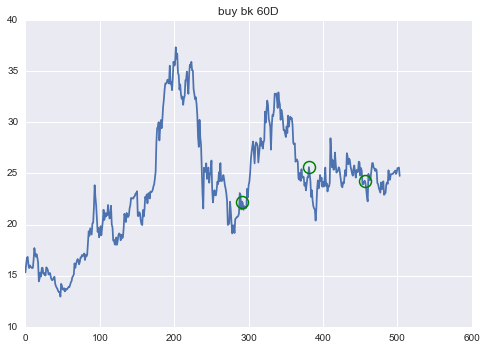

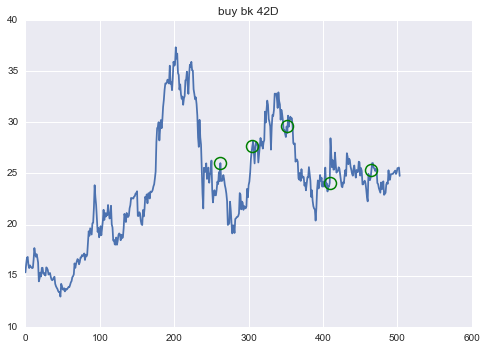

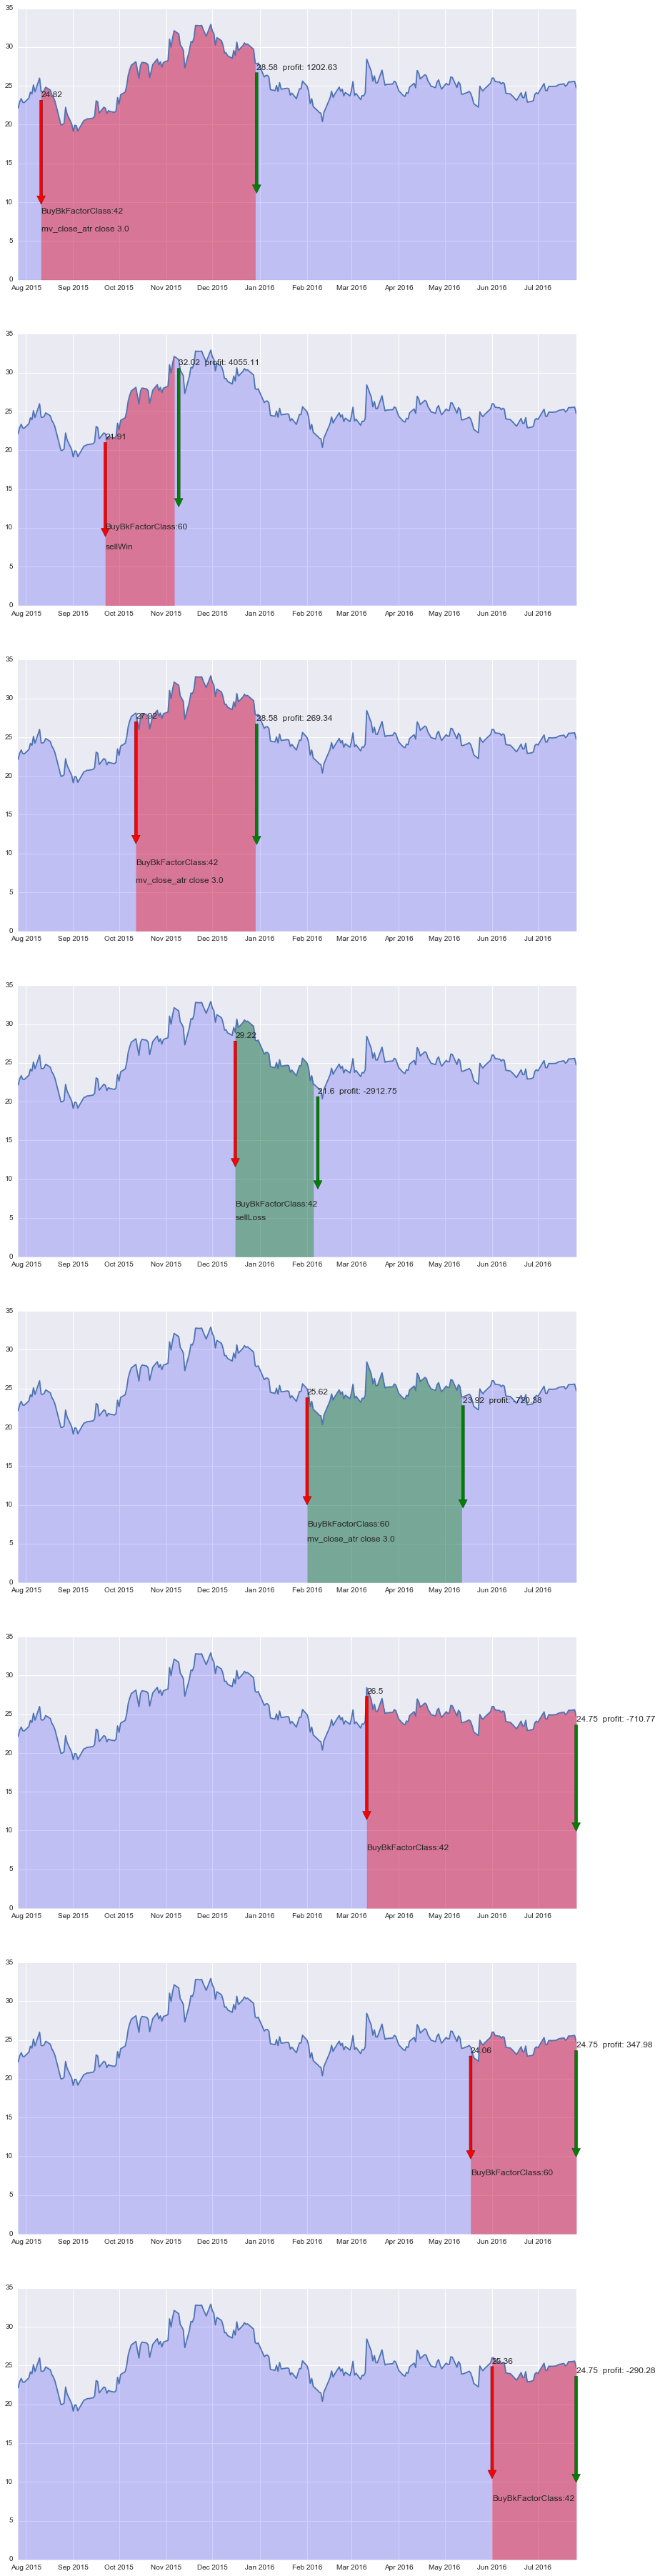

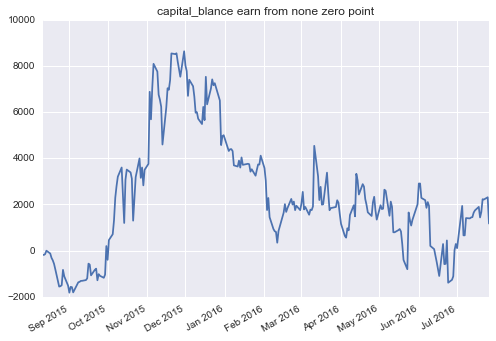

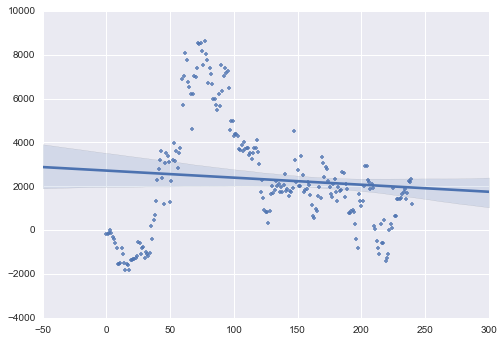

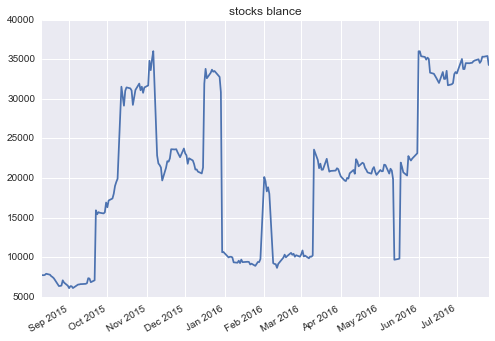

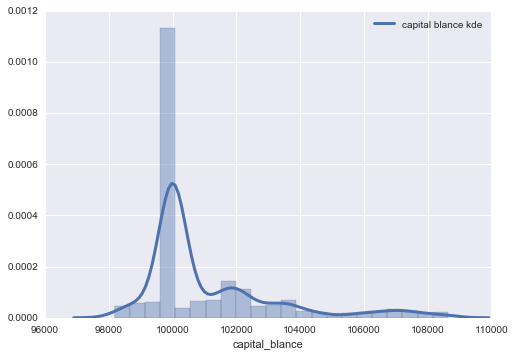

In [3]:
"""
    设置60，42日突破买入因子
    []无卖出因子，所以所有卖出只能靠alpha本身
"""
base_trade_sample([{'XD': 60, 'class': BuyBkFactorClass, 'draw': True} ,
                   {'XD': 42, 'class': BuyBkFactorClass, 'draw': True}], [])

**模型空转最佳结果应该是n个测试集下结果不大跌, 随个股走势进步平稳行进，加入真实有能力的因子才是真实情况**

************************************************************************************************************
set(['usNOAH'])
simple profit: -2614.1
mean win profit 1165.8
mean loss profit -539.987142857
win rate 0.125%


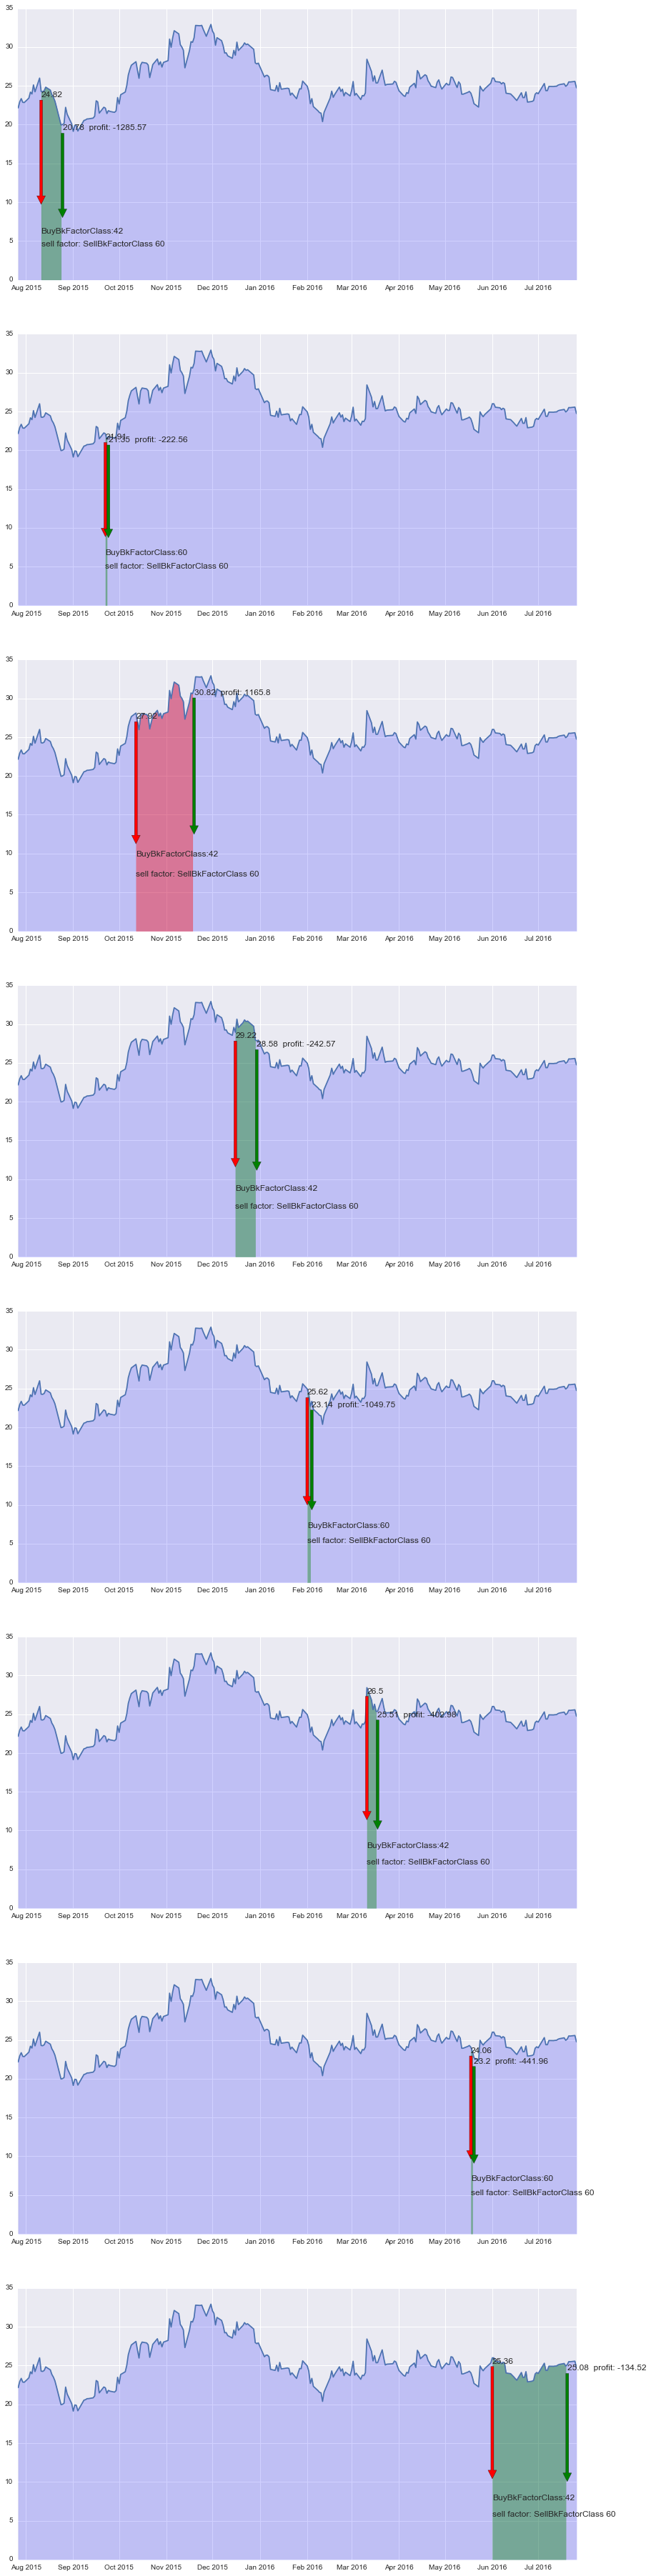

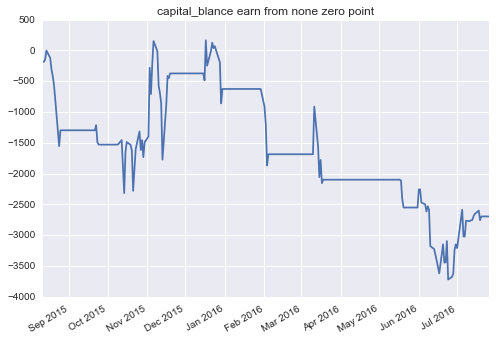

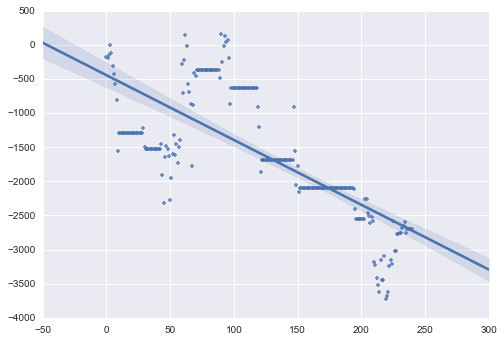

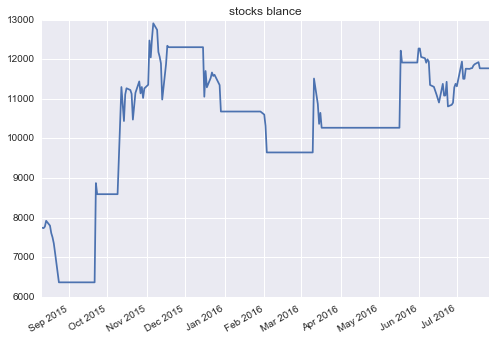

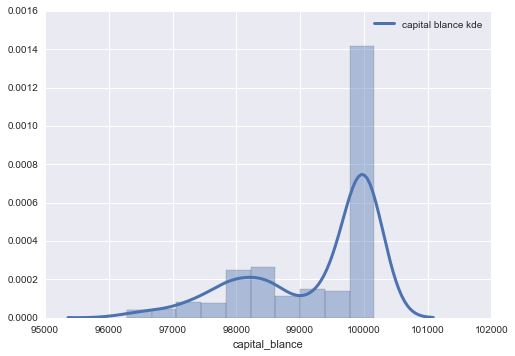

In [4]:
"""
    设置60，42日突破买入因子
    60, 120卖出因子
"""
base_trade_sample([{'XD': 60, 'class': BuyBkFactorClass, 'draw': False} ,
                   {'XD': 42, 'class': BuyBkFactorClass, 'draw': False}], 
                  [{'XD': 60, 'class': SellBkFactorClass, 'draw': False}, 
                   {'XD': 120, 'class': SellBkFactorClass, 'draw': False}])

## 更一般使用do_symbols_with_same_factors | do_symbols_with_diff_factors

### do_symbols_with_same_factors:单个或者多个股票，n个因子，每个股票上承载一样的因子

In [5]:
parameters = {
                  'stop_win_base_n'    : 3.0,
                  'stop_loss_base_n'   : 2.0,
                  'mv_close_atr': 3.0,
                  'mv_pre_atr'  : 1.5,
             }

buy_factors = [{'XD': 60, 'class': BuyBkFactorClass, 'draw': True},
               {'XD': 42, 'class': BuyBkFactorClass, 'draw': True}]

sell_factors = [{'XD': 60, 'class': SellBkFactorClass, 'draw': True}, 
                {'XD': 120, 'class': SellBkFactorClass, 'draw': True}]

target_symbols = ['usNOAH', 'usSFUN', 'usBIDU', 'usAAPL', 'usGOOG', 'usTSLA', 'usWUBA', 'usVIPS']

1. 对于不同参数相同的因子其实认为是不同的因子
2. ‘has duplicated will remove’ 针对不同因子产生的重复买单现在策略是只保留一个
3. ‘Can't excute order for cash not enought’ 只针对初始设置的资金交易，没有涉及资金放大等问题

In [6]:
cap = CapitalClass(1000000)
results, orders_pd, action_pd, all_fit_symbols = AlphaBSellMvEstimator.do_symbols_with_same_factors(target_symbols, buy_factors, sell_factors, parameters, cap,
                                                 scoring=Metrics.K_RMULT, show=False)

usWUBA : date:20150930 has duplicated will remove
usWUBA: date : 20160601 : Can't excute order for cash not enought
usVIPS: date : 20151104 : Can't excute order for cash not enought
usVIPS: date : 20160601 : Can't excute order for cash not enought


In [7]:
import MetricsManger
from MetricsManger import metrics_rsc
from FactorMetrics import METRICSTYPE

**关于模型度量metrics 更多查看模型度量部分**

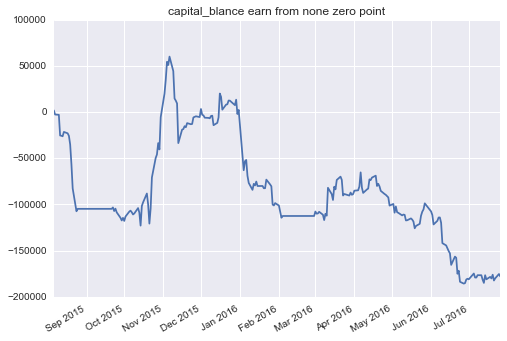

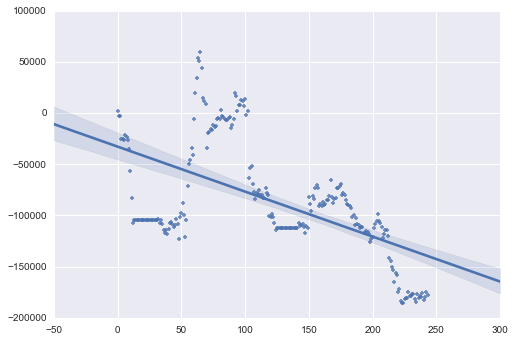

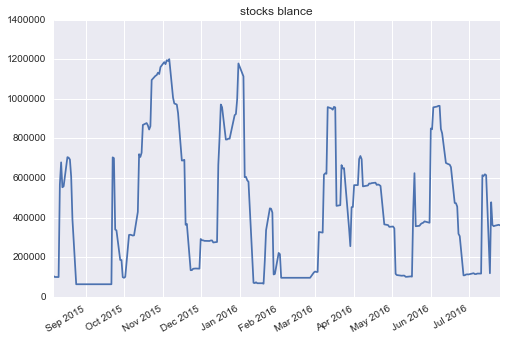

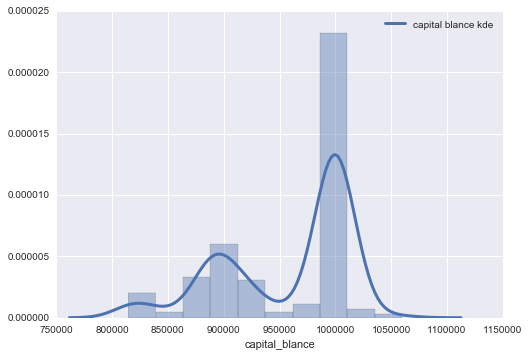

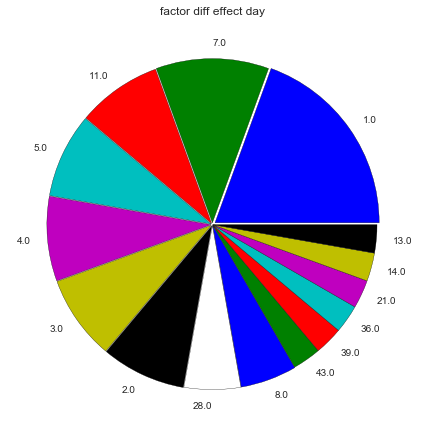

effect mean day: 9.66666666667


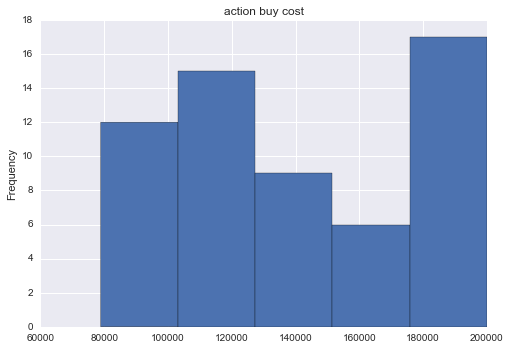

cost info: 
moments_tuple(mean=141419.3043813559, std=41737.8507986827, skewness=0.2113344387800186, kurtosis=1.5882221206753873)


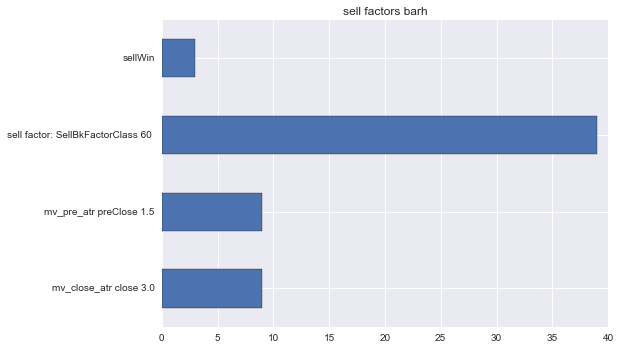

mv_close_atr close 3.0                 9.0
mv_pre_atr preClose 1.5                9.0
sell factor: SellBkFactorClass 60     39.0
sellWin                                3.0
dtype: float64


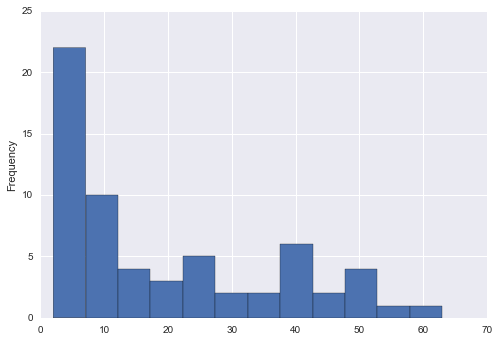

keep days mean: 19.9838709677
keep days median: 12.0


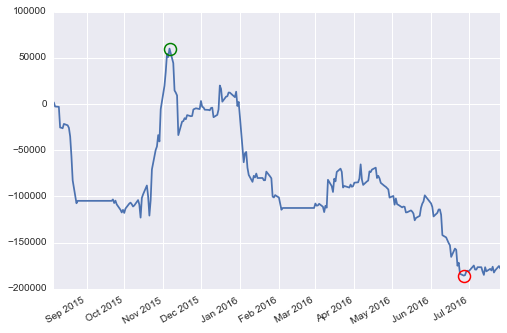

max down rate: 0.231752640954
{(Timestamp('2015-11-06 00:00:00'), Timestamp('2016-06-27 00:00:00')): 245665.42499999981}


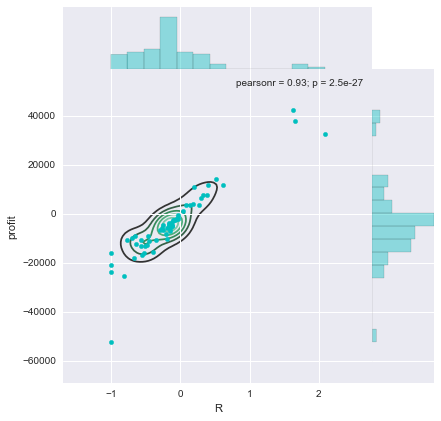

factor effect symbol rate: 1.0
factor gen order rate: 7.375

R win rate: 0.125
result win rate: 0.241935483871
R return: -0.986705489494
P return: -0.0305778467302
C return: -0.177819671
C PB:      -439.848172076

order win mean: 13357.8066667 cg: 10.3229561511
order win max: 42292.59 cg: 31.9318642693

Win Top 5
2015-10-05    31.931864
2015-10-16    30.993183
2015-10-13    16.416186
2015-09-30    14.960630
2016-03-08    11.022700
Name: profit_cg_hunder, dtype: float64

order loss mean: -9672.954 cg: -7.51803161438
order loss max: -52102.54 cg: -41.0991733868

2015-11-04   -41.099173
2015-10-05   -28.442535
2015-12-15   -20.188346
2015-08-11   -16.466431
2015-08-11   -16.240177
Name: profit_cg_hunder, dtype: float64



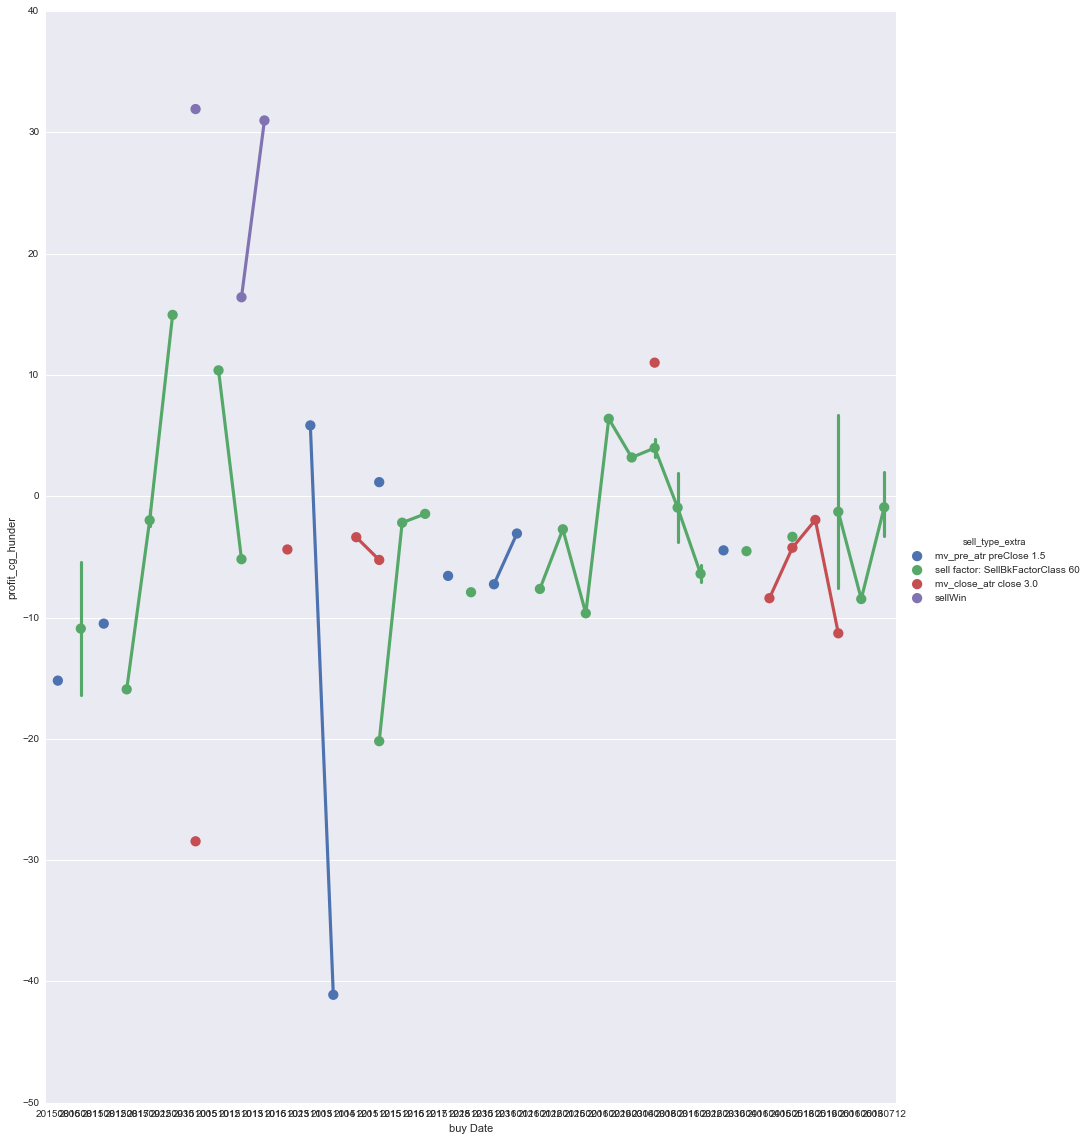

top 10 win profit_cg mean: 14.3339301147
top 10 loss profit_cg  mean: -18.5019760052


In [8]:
rsc = metrics_rsc(*(cap, results, orders_pd, action_pd, all_fit_symbols))
MetricsManger.make_metrics_from_rsc(rsc, METRICSTYPE.SYSMBOL_R_SCORES.value)

### do_symbols_with_diff_factors: m个股票，n * m个因子，每个股票上承载自己独有的因子组合

In [9]:
cap = CapitalClass(100000)

target_symbols = ['usSFUN', 'usNOAH']

parameters_sfun = {
                  'stop_win_base_n'    : 3.0,
                  'stop_loss_base_n'   : 2.0,
                  'mv_close_atr': 3.0,
                  'mv_pre_atr'  : 1.5,
                 }
buyFactors_sfun = [{'XD': 60, 'class': BuyBkFactorClass, 'draw': True},
               {'XD': 42, 'class': BuyBkFactorClass, 'draw': True}]
sellFactors_sfun = [{'XD': 60, 'class': SellBkFactorClass, 'draw': True}, 
                {'XD': 120, 'class': SellBkFactorClass, 'draw': True}]


parameters_noah = {
                  'stop_win_base_n'    : 2.0,
                  'stop_loss_base_n'   : 1.0,
                  'mv_close_atr': 3.0,
                  'mv_pre_atr'  : 1.5,
                 }
buyFactors_noah = [{'XD': 21, 'class': BuyBkFactorClass, 'draw': True}]
sellFactors_noah = [{'XD': 42, 'class': SellBkFactorClass, 'draw': True}]


factor_dict = dict()
factor_dict['usSFUN'] = {'parameters':parameters_sfun, 'buyFactors':buyFactors_sfun, 'sellFactors':sellFactors_sfun}
factor_dict['usNOAH'] = {'parameters':parameters_noah, 'buyFactors':buyFactors_noah, 'sellFactors':sellFactors_noah}


results, orders_pd, action_pd, all_fit_symbols = AlphaBSellMvEstimator.do_symbols_with_diff_factors(target_symbols, factor_dict, cap,
                                                 scoring=Metrics.K_RMULT, show=False)

In [10]:
orders_pd.tail()

,buy Date,buy Price,buy Cnt,buyFactor,Sell Date,Sell Price,Sell Type,Symbol,MaxLoss,ExtraInfo,key,profit,result,sell_type_extra,R
2016-03-30,20160330,25.0750,392,BuyBkFactorClass:21,20160421,25.4150,win,usNOAH,21.49,None,422,133.28,1,sell factor: SellBkFactorClass 42,0.094840
2016-04-01,20160401,5.8625,1818,BuyBkFactorClass:60,20160518,5.5975,loss,usSFUN,3.56,None,424,-481.77,-1,sell factor: SellBkFactorClass 60,-0.115092
2016-06-01,20160601,25.3650,472,BuyBkFactorClass:21,20160613,24.0650,loss,usNOAH,21.78,None,466,-613.60,-1,sell factor: SellBkFactorClass 42,-0.362622
2016-06-03,20160603,5.3150,2276,BuyBkFactorClass:42,20160609,4.8650,loss,usSFUN,3.01,None,468,-1024.20,-1,sell factor: SellBkFactorClass 60,-0.195228
2016-07-06,20160706,24.6800,538,BuyBkFactorClass:21,20160712,24.9650,win,usNOAH,21.09,None,489,153.33,1,sell factor: SellBkFactorClass 42,0.079387


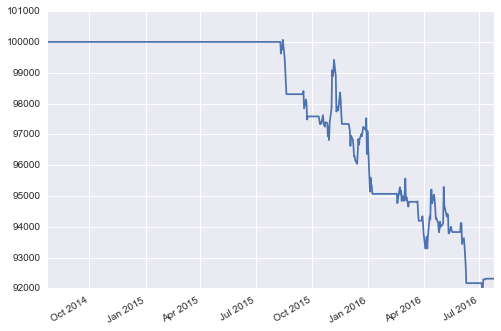

In [11]:
cap.capital_pd.capital_blance.plot()

## **寻找合适的alpha参数组合**

    初始给定参数约束范围，之后GridHelper等方式生成参数的排列组合序列

In [12]:
import numpy as np
import GridHelper
from GridSearch import GridSearchCV

close_atr = np.arange(2.0, 4.0, 0.5)
pre_atr = np.arange(1.5, 3.0, 0.5)
win = np.arange(2.0, 4.0, 0.5)
loss = np.arange(0.5, 1.5, 0.5)
parameters = {
                  'stop_win_base_n'    : win,
                  'stop_loss_base_n'   : loss,
                  'mv_close_atr': close_atr,
                  'mv_pre_atr'  : pre_atr,
                  }

bk_days = [21, 42]
sell_bk_factor_grid = {
              'class': [SellBkFactorClass],
              'XD'   : bk_days,
              'draw'  : [True],
         }
bk_days2 = [60]
sell_bk_factor_grid2 = {
              'class': [SellBkFactorClass],
              'XD'   : bk_days2,
              'draw'  : [True],
         }
sell_factor_prams = GridHelper.gen_factor_grid(GridHelper.K_GEN_FACTOR_PARM_SELL, *[sell_bk_factor_grid, sell_bk_factor_grid2])


buy_bk_factor_grid = {
              'class': [BuyBkFactorClass],
              'XD'   : [60],
              'draw'  : [True],
         }
buy_bk_factor_grid2 = {
              'class': [BuyBkFactorClass],
              'XD'   : [120],
              'draw'  : [True],
         }
buy_factor_prams = GridHelper.gen_factor_grid(GridHelper.K_GEN_FACTOR_PARM_BUY, *[buy_bk_factor_grid, buy_bk_factor_grid2])

sell_factor_prams, buy_factor_prams, parameters

([[{'XD': 21, 'class': SellBkFactor.SellBkFactorClass, 'draw': True},
   {'XD': 60, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  [{'XD': 42, 'class': SellBkFactor.SellBkFactorClass, 'draw': True},
   {'XD': 60, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  [{'XD': 21, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  [{'XD': 42, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  [{'XD': 60, 'class': SellBkFactor.SellBkFactorClass, 'draw': True}],
  []],
 [[{'XD': 60, 'class': BuyBkFactor.BuyBkFactorClass, 'draw': True},
   {'XD': 120, 'class': BuyBkFactor.BuyBkFactorClass, 'draw': True}],
  [{'XD': 60, 'class': BuyBkFactor.BuyBkFactorClass, 'draw': True}],
  [{'XD': 120, 'class': BuyBkFactor.BuyBkFactorClass, 'draw': True}]],
 {'mv_close_atr': array([ 2. ,  2.5,  3. ,  3.5]),
  'mv_pre_atr': array([ 1.5,  2. ,  2.5]),
  'stop_loss_base_n': array([ 0.5,  1. ]),
  'stop_win_base_n': array([ 2. ,  2.5,  3. ,  3.5])})

**GridSearchCV 最合所有参数及因子的拟合**

    scoring：度量输出结果的方式
    Metrics.K_QUANT, Metrics.K_RSMM 只可用于grid情况下
    横向对比
            K_QUANT：认为最好的模型按照时间 bestQuant = [0.0, 0.25, 0.75, 1.0] 排序
            标准化所有模型结果度量差距
            K_RSMM： 高，收，平均与标准差的关系数
                     主要提取模型的平稳性，独立使用
                     并不能有很好的评价模型
            更多度量详情查看Metrics，Scorer
            
            scoring_weight：对赋予scoring的各种度量方式分配记分权重
                            Scorer.scaler_standard_min_max：对多个分数在分配权重前标准化分数，类似penalty大分数，
                            避免由于某个分数基础值过大，导致影响的问题

best is :{'stop_loss_base_n': 0.5, 'mv_pre_atr': 1.5, 'mv_close_atr': 3.0, 'stop_win_base_n': 2.0}  sellFactor: []  buyFactor: [{'draw': True, 'class': <class 'BuyBkFactor.BuyBkFactorClass'>, 'XD': 120}]


************************************************************************************************************
set(['usNOAH'])
simple profit: [ 483.834]
mean win profit 833.7
mean loss profit nan
win rate 1.0%


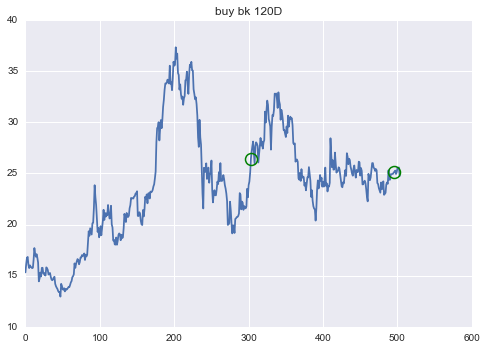

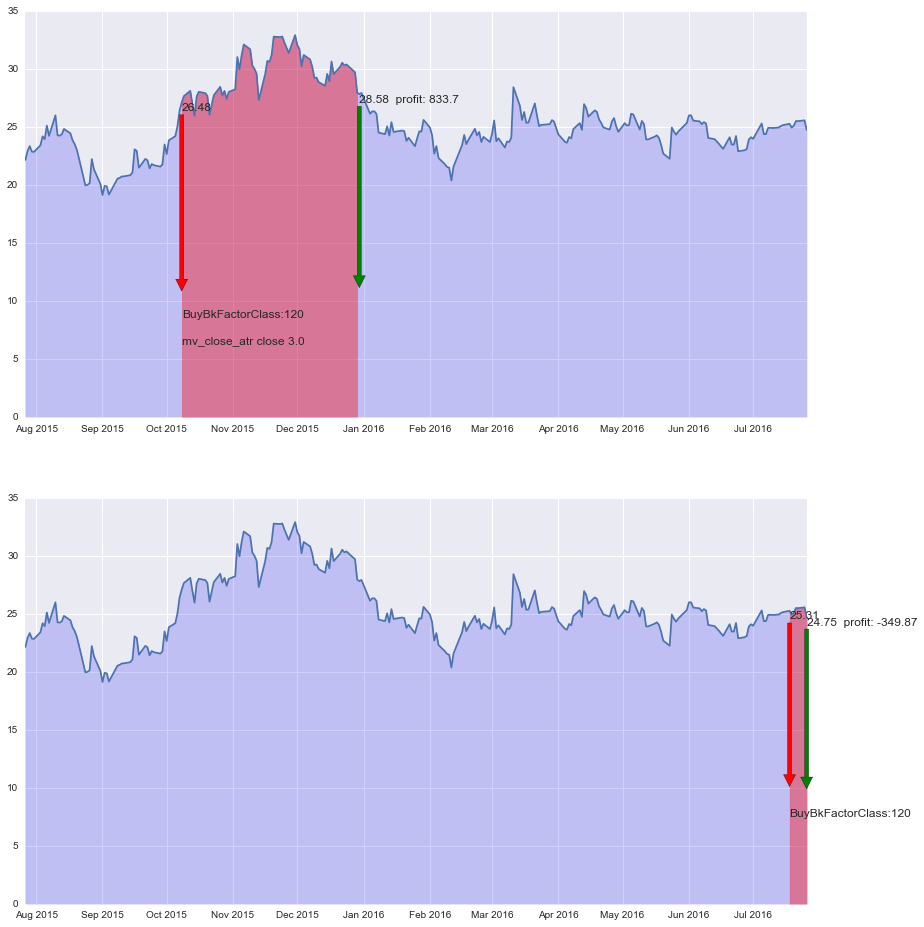

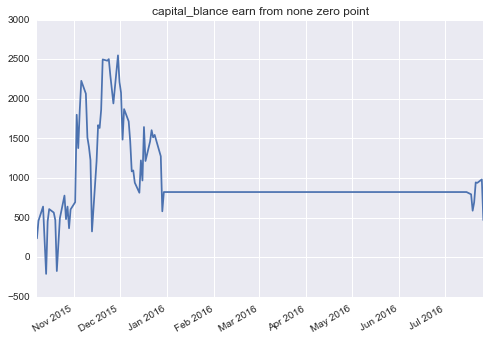

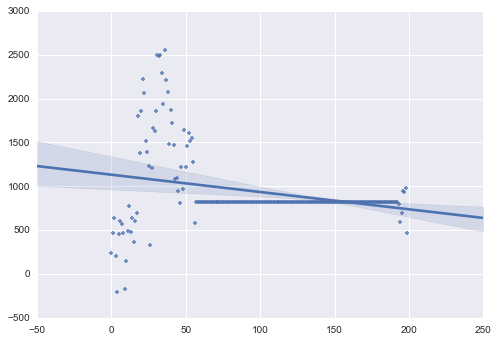

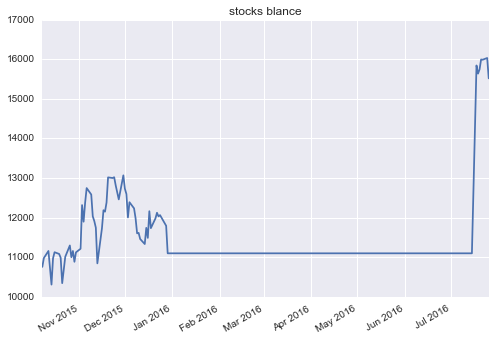

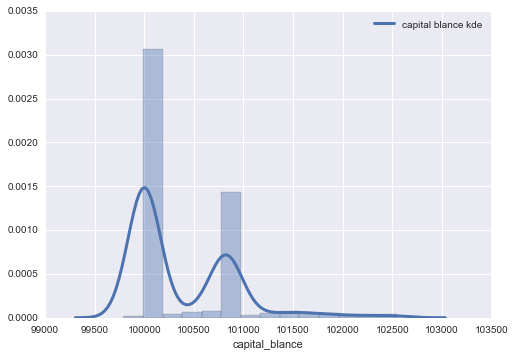

GridSearchCV({'scoring': ['QUANT', 'RSMM', 'SHARP', 'RMULT'], 'sell_factor_prams': None, 'n_jobs': -1, 'standar_sc': True, 'scoring_weight': [0.3, 0.2, 0.2, 0.3], 'estimator': AlphaBSellMvEstimator({'stop_win_base_n': -1, 'mv_pre_atr': 0.0, 'stop_loss': inf, 'stop_loss_base_n': -1, 'stop_win': inf, 'n_jobs': 1, 'weights': 'uniform', 'mv_close_atr': 0.0}), 'pre_dispatch': '2*n_jobs', 'param_grid': {'stop_win_base_n': array([ 2. ,  2.5,  3. ,  3.5]), 'mv_pre_atr': array([ 1.5,  2. ,  2.5]), 'mv_close_atr': array([ 2. ,  2.5,  3. ,  3.5]), 'stop_loss_base_n': array([ 0.5,  1. ])}})

In [14]:
# cap, capklPd, klPd, buyFactorPrams, False
target_symbol = 'usNOAH'
target_count  = SymbolPd.K_N_GET_DAY_YEAR

cap = CapitalClass(100000)
kl_pd = SymbolPd.make_kfold_pd(target_symbol, target_count, cap=cap, n_folds=2)
kl_pd.name = target_symbol
test_pd = kl_pd[-target_count:]
test_pd.name = target_symbol

svr = AlphaBSellMvEstimator()
clf = GridSearchCV(svr, parameters, n_jobs=-1, 
                    scoring=[Metrics.K_QUANT, Metrics.K_RSMM, Metrics.K_SHARP, Metrics.K_RMULT], 
                    scoring_weight=[0.3, 0.2, 0.2, 0.3],
                    sell_factor_prams=sell_factor_prams)
clf.fit_with_buy_factor(cap, test_pd, kl_pd, buy_factor_prams, False)

In [26]:
# ZCommonUtil.dump_pickle(clf, './data/cache/grid_search_clf_abu')

In [27]:
# clf_load = ZCommonUtil.load_pickle('./data/cache/grid_search_clf_abu')
# clf = clf_load

**最后输出plot的是最优模型参数及因子组合**

        clf.grid_scores_：所有组合的分数
        grid_scores[0][0][0] 最终加权分数
        

In [15]:
grid_scores = clf.grid_scores_
ZLog.info(grid_scores[0])
grid_scores[0][0][0]

[[3.39223959582824, 4.428993364243846, 4.321218995126834, 4.514481688561519, 0.9880048327247186], {'stop_loss_base_n': 0.5, 'mv_pre_atr': 1.5, 'mv_close_atr': 3.0, 'stop_win_base_n': 2.0}, [], [{'draw': True, 'class': <class 'BuyBkFactor.BuyBkFactorClass'>, 'XD': 120}], [{'quant': 0.96870531019629336}, {'rsmm': -0.096345846764633841}, 5.11580595352178, 0]]


3.39223959582824

**GridHelper.make_grid_score_pd**
        
        根据各自参数因子组合生成pandas
        Y_REG 最终分数
        Y_LOG_MEDIAN: grid_pd['Y_REG'].median()
        Y_LOG_618: stats.scoreatpercentile(grid_pd['Y_REG'], 61.8)

In [16]:
import pandas as pd
pd.options.display.max_rows = 12
grid_pd = GridHelper.make_grid_score_pd(grid_scores)

In [ ]:
grid_pd

**可视化综合评定参数的设定和因子的选择**
        
        如下可看出: mv_close_atr设置应该小于2.5
                  pre_atr 1.5-2.5对模型几乎没产生影响等

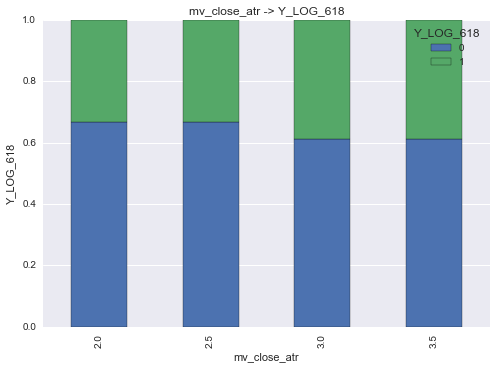

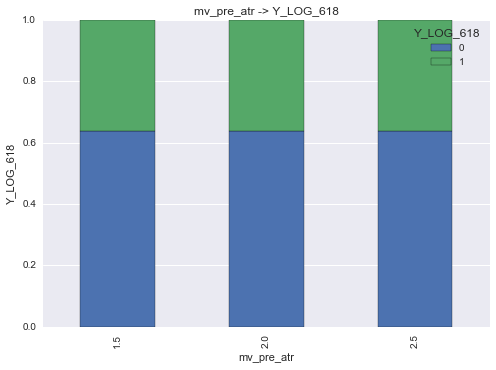

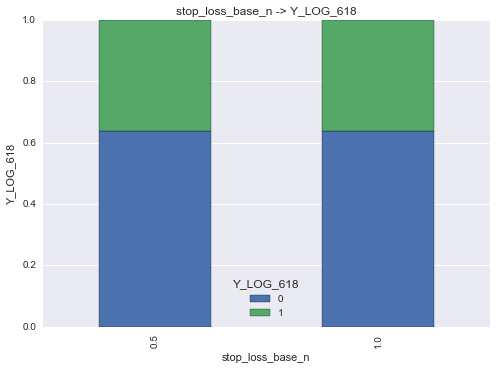

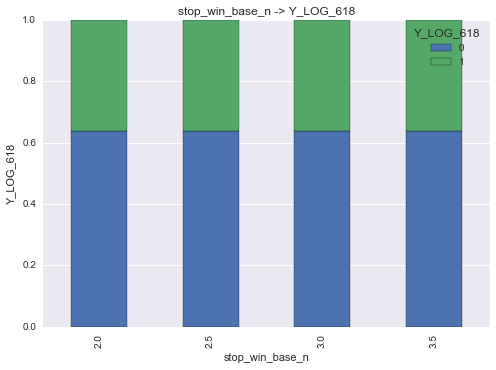

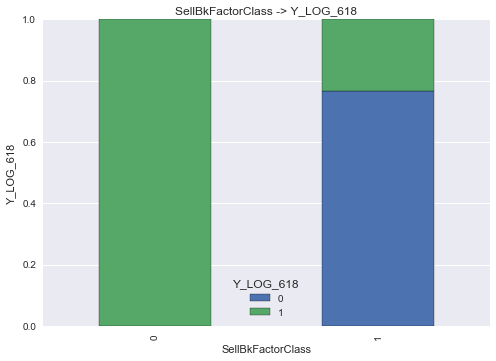

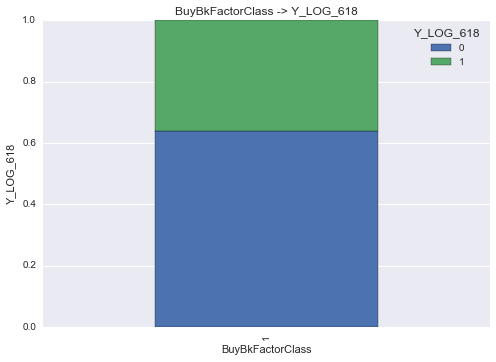

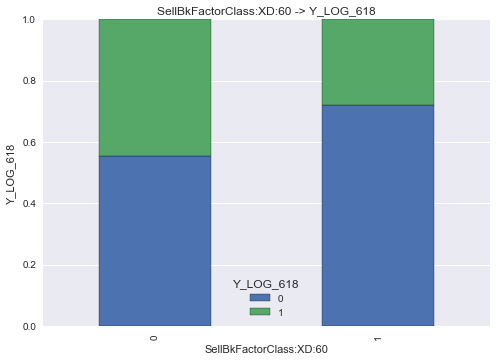

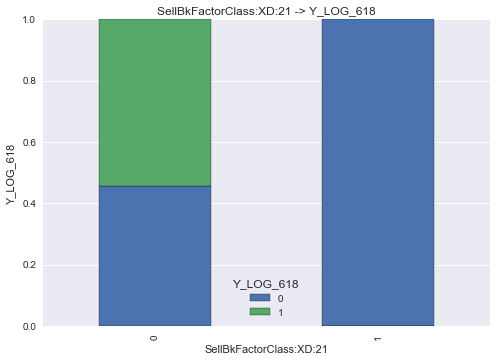

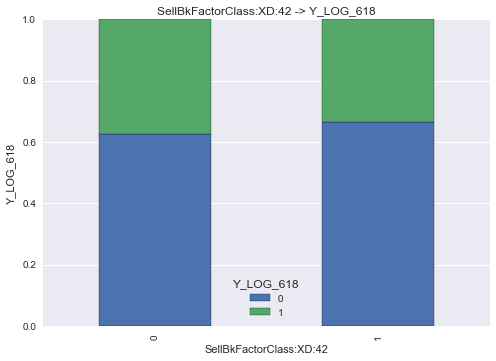

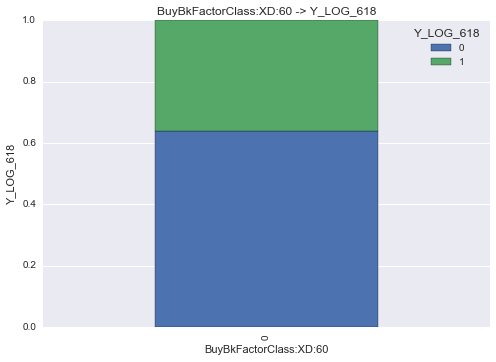

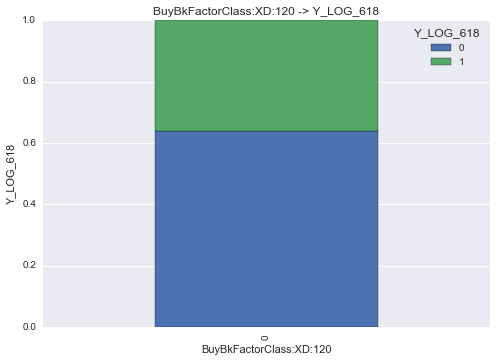

In [17]:
GridHelper.score_pd_plot(grid_pd, 'Y_LOG_618')

* AlphaBSellMvEstimator.do_from_done_factor: 可从clf.best_buy_factor_params_, clf.best_sell_factor_params_拿出
进行拟合测试
* AlphaBSellMvEstimator.do_from_grid_scores: 从gird分数中拿出某个查看

### 交叉测试
        cv个正相关，cv个负相关，cv个分段相关pd.qcut
        组合交叉测试grid输出的最优结果clf.best_buy_factor_params_，
        clf.best_sell_factor_params_, clf.best_params_